In [12]:
import sys
sys.path.append('../')
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".20"
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../utils/ppt.mplstyle')
from mpl_toolkits.axes_grid1 import ImageGrid
from pathlib import Path
import h5py 
import yaml
with open('../system_config.yml','r') as stream:
    sysconfig = yaml.safe_load(stream)

import utils.simulation2d as project
from flowrec.data import DataMetadata
from flowrec.physics_and_derivatives import momentum_residual_field, div_field
from flowrec.losses import divergence
from utils.py_helper import slice_from_tuple
data_dir = Path(sysconfig['data_dir'],'re100new')
dt = 0.125

In [2]:
# (ux,uy,pp) = project.read_data(data_dir,idx_body=132)
(ux,uy,pp) = project.read_data(data_dir,idx_body=0)
# take base measurement
pb = project.take_measurement_base(pp, ly=[1.5,2.5] ,centrex=0, domain_y=4)

In [3]:
pp.shape

(800, 513, 129)

## Residual

In [4]:
datainfo = DataMetadata(
    re=100,
    discretisation=[0.125, 12/512, 4/128],
    axis_index=[0,1,2],
    problem_2d=True
).to_named_tuple()
(u1,u2,pressure) = project.read_data(data_dir,idx_body=132)
loss_mom = np.mean(
    momentum_residual_field(
        u_p=np.stack((u1[:600,...,np.newaxis],u2[:600,...,np.newaxis],pressure[:600,...,np.newaxis]),axis=-1),
        datainfo=datainfo
    )**2
)*2
loss_div = divergence(
    u=np.stack((u1[:600,...,np.newaxis],u2[:600,...,np.newaxis]),axis=-1),
    datainfo=datainfo
)
lp = loss_mom+loss_div
print(f'The losses of true data - physics {lp}, momentum {loss_mom}, divergence {loss_div}.')

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


The losses of true data - physics 0.017343152314424515, momentum 0.017321951687335968, divergence 2.1199757611611858e-05.


## Plot data

/home/ym917/anaconda3/envs/fr/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


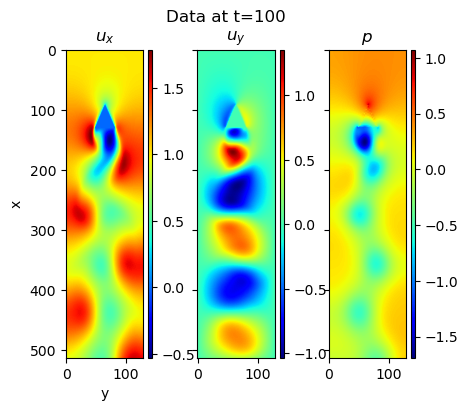

In [5]:
fig = plt.figure(figsize=(12,4))
fig.suptitle('Data at t=100')
grid = ImageGrid(fig,111,nrows_ncols=(1,3),cbar_mode='each',axes_pad=0.45,cbar_pad=(0.05),share_all=True)
ax = grid.axes_all
cax = grid.cbar_axes
ax[0].set(xlabel='y',ylabel='x')
im0 = ax[0].imshow(ux[100,...],'jet')
cax[0].colorbar(im0)
ax[0].set_title('$u_x$')
im1 = ax[1].imshow(uy[100,...],'jet')
cax[1].colorbar(im1)
ax[1].set_title('$u_y$')
im2 = ax[2].imshow(pp[100,...],'jet')
cax[2].colorbar(im2)
ax[2].set_title('$p$')
plt.show()

In [6]:
probe_location = (150-132,60)
probe_ux = ux[:,probe_location[0],probe_location[1]]
probe_uy = uy[:,probe_location[0],probe_location[1]]
probe_p = pb[:,probe_location[1]-49]

freq = np.fft.fftfreq(len(probe_ux),d=dt)
f_ux = np.fft.fft(probe_ux-np.mean(probe_ux))/len(probe_ux)
f_uy = np.fft.fft(probe_uy-np.mean(probe_uy))/len(probe_uy)
f_p = np.fft.fft(probe_p-np.mean(probe_p))/len(probe_p)

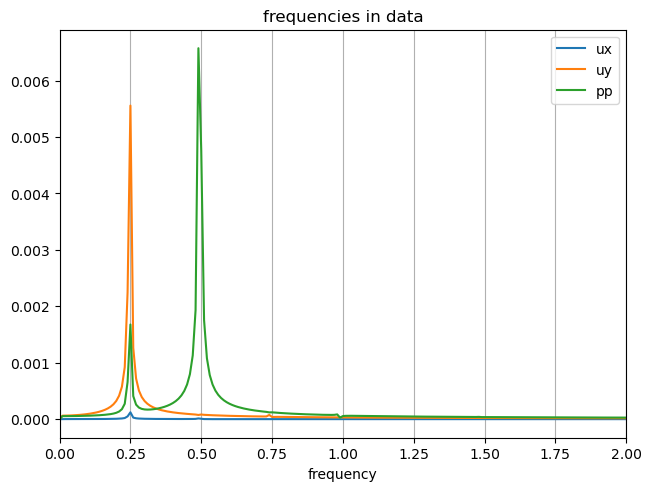

highest peak at  -0.24  Hz.


In [7]:
plt.figure()
plt.plot(freq[:int(len(freq)/2)],np.abs(f_ux)[:int(len(freq)/2)],label ='ux')
plt.plot(freq[:int(len(freq)/2)],np.abs(f_uy)[:int(len(freq)/2)],label ='uy')
plt.plot(freq[:int(len(freq)/2)],np.abs(f_p)[:int(len(freq)/2)],label ='pp')
plt.title('frequencies in data')
plt.xlabel('frequency')
plt.xlabel('frequency')
plt.xlim([0,2])
plt.legend()
plt.grid(True, which='both', axis='x')
plt.show()
idx_sort = np.argsort(f_uy)
high_freq = freq[idx_sort][-1]
print("highest peak at ", high_freq, " Hz.")

In [8]:
amp = np.abs(f_uy[idx_sort][-1])
phase = np.angle(f_uy[idx_sort][-1])

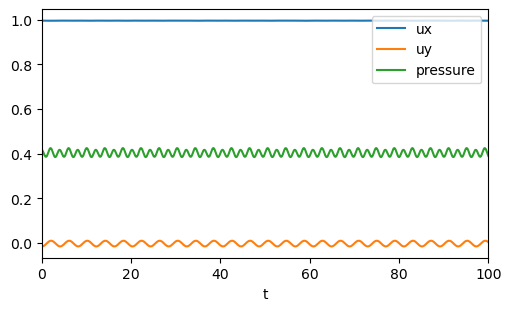

In [9]:
t = np.linspace(0,probe_ux.shape[0]*dt,probe_ux.shape[0])
plt.figure(figsize=(5,3))
# plt.title("$Re=100$")
plt.plot(t,probe_ux,label='ux')
plt.plot(t,probe_uy,label='uy')
plt.plot(t,probe_p,label='pressure')
# plt.plot(t,2*amp*np.cos(high_freq*2*np.pi*t+phase),label='main fft freq')
plt.legend(loc='upper right')
plt.xlim([0,100])
plt.xlabel("t")
plt.show()

# Uz

In [12]:
if Path(data_dir,"uz.h5").exists():
    with h5py.File(Path(data_dir,"uz.h5"),'r') as hf:
        uz = np.array(hf.get('uz'))

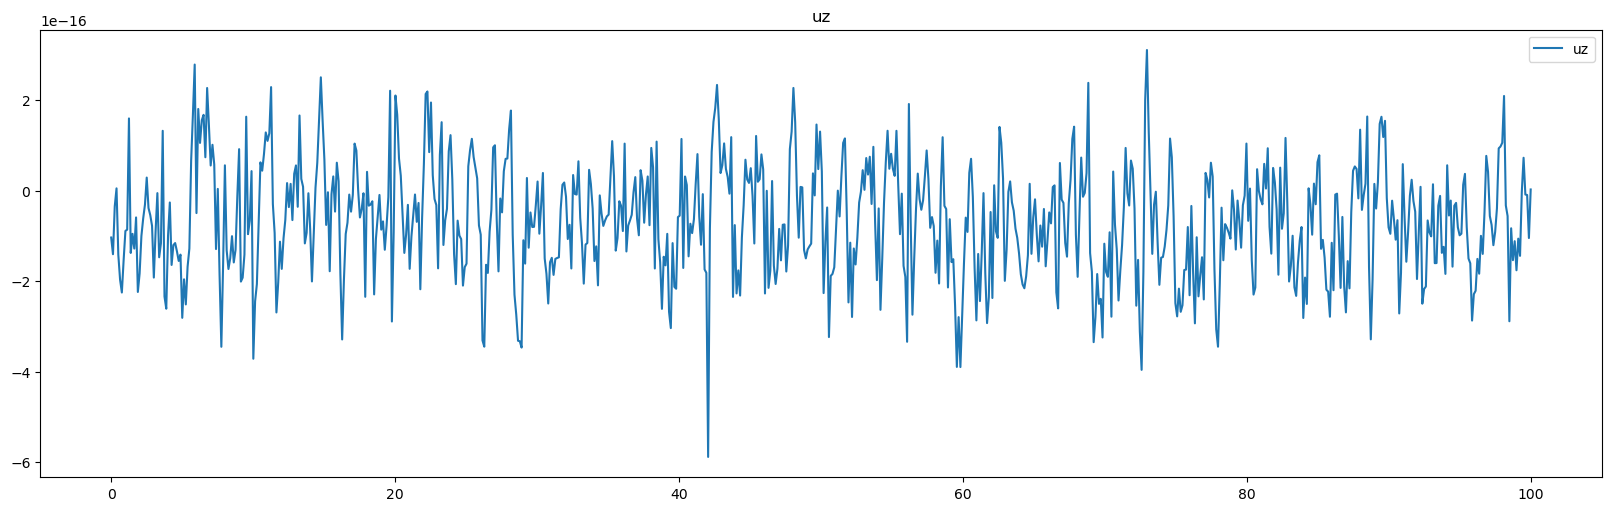

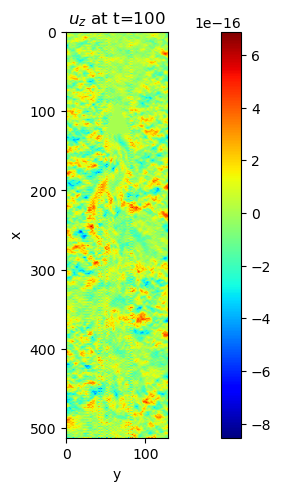

In [30]:
t = np.linspace(0,uz.shape[0]*dt,uz.shape[0])
plt.figure(figsize=(16,5))
plt.plot(t,uz[:,150,60],label='uz')
plt.legend()
plt.title('uz')

plt.figure()
plt.title('$u_z$ at t=100')
plt.imshow(uz[0,:,:])
plt.colorbar()
plt.xlabel('y')
plt.ylabel('x')

plt.show()

# Vorticity

In [27]:
with h5py.File(Path(data_dir,'vort.h5'),'r') as hf:
    vort = np.array(hf.get('vort'))
with h5py.File(Path(data_dir,'critq.h5'),'r') as hf:
    critq = np.array(hf.get('critq'))
vort.shape

(800, 513, 129)

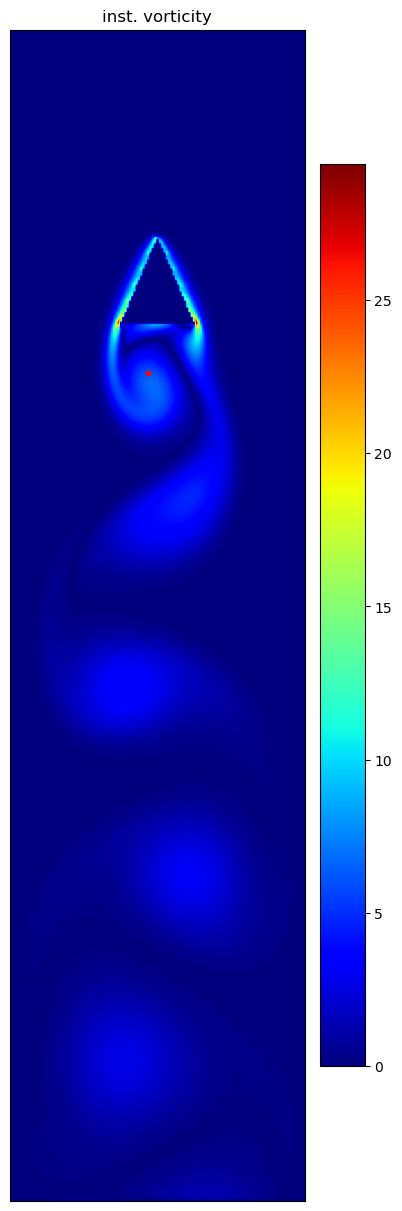

In [28]:
plt.figure(figsize=(4,12))
plt.title('inst. vorticity')
plt.imshow(vort[200,...],'jet')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.scatter(60,150,s=10,c='r')
plt.show()

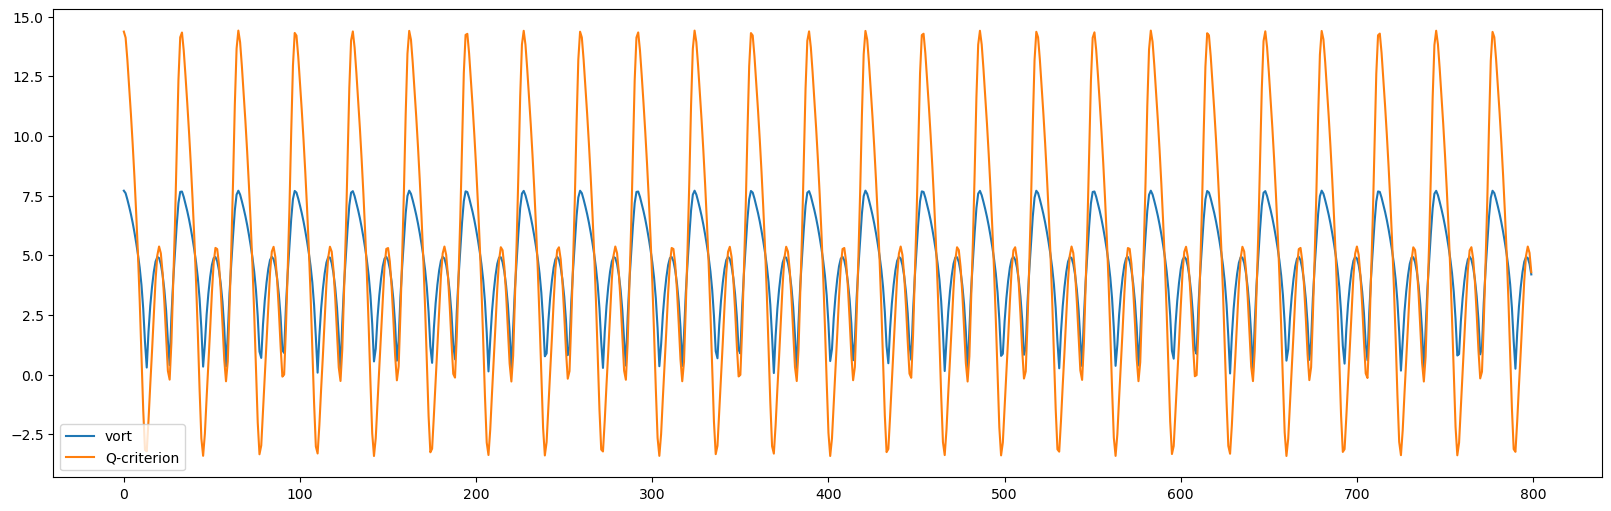

In [29]:
probe_vort = vort[:,150,60]
probe_q = critq[:,150,60]
plt.figure(figsize=(16,5))
plt.plot(probe_vort,label='vort')
plt.plot(probe_q,label='Q-criterion')
plt.legend()
plt.show()


# Locations of the sensors

In [10]:
triangle_base_coords = [49,80]
(ux_short,uy_short,pp_short) = project.read_data(data_dir, idx_body=132)
x = np.stack([ux_short,uy_short,pp_short],axis=0)
x = x[:,:,:250,:]
ux_short.shape

(800, 381, 129)

### Grid

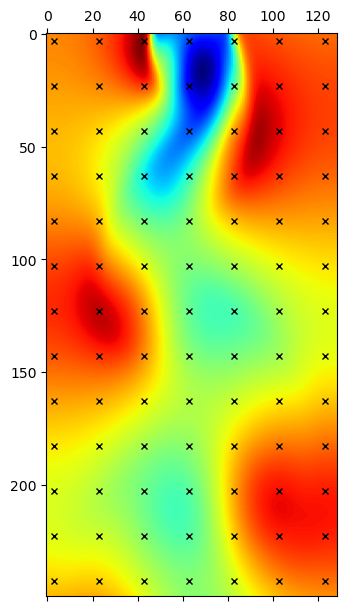

In [29]:
slice_tuple = ((3,None,20),(3,None,20))
sensor_index = (np.s_[:],) + slice_from_tuple(slice_tuple)


observed_plot = np.empty_like(ux_short[:,:250,:])
observed_plot.fill(np.nan)
observed_plot[sensor_index] = ux_short[:,:250,:][sensor_index]
plt.figure(figsize=(4,6))
plt.imshow(ux_short[0,:250,:])
plt.spy(observed_plot[0,...],color='k',marker='x',markersize=5)
plt.show()



### By hand
Pick any arbitrary points

16


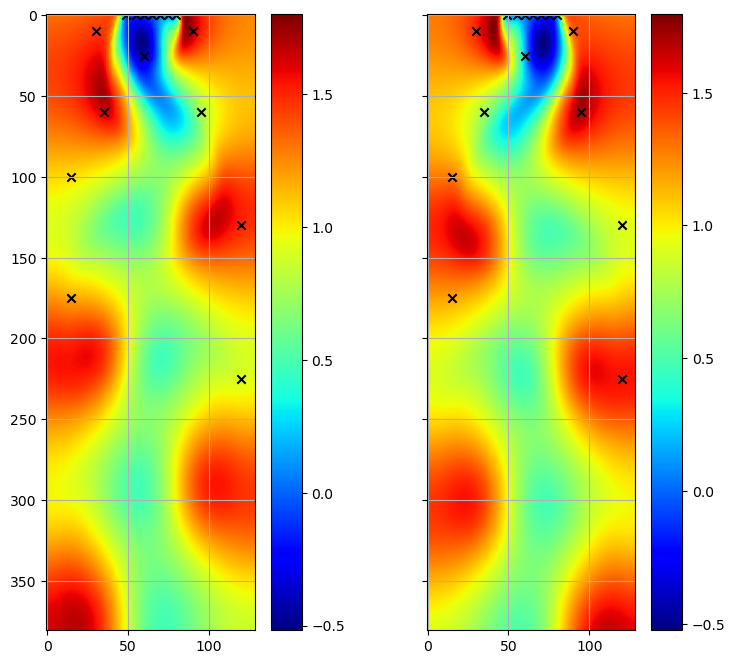

In [8]:
fig,ax = plt.subplots(1,2,figsize=(9,8),sharex=True,sharey=True)
# fig = plt.figure(figsize=(4,8))
im0 = ax[0].imshow(ux_short[500,...],'jet')
plt.colorbar(im0)
ax[0].grid(True, 'both')
im1 = ax[1].imshow(ux_short[0,...],'jet')
plt.colorbar(im1)
ax[1].grid(True, 'both')

# add sensors here
xi = (0, 0, 0, 0, 0, 0, 0, 10,10,25,60,60,100,130,175,225)
yi = (49,55,60,65,70,75,80,30,90,60,35,95, 15,120, 15,120)




sensors = (yi,xi)
ax[0].scatter(*sensors,marker='x',c='k')
ax[1].scatter(*sensors,marker='x',c='k')


print(len(xi))
plt.show()

### max and min from POD
The the maximum and minimum of the first few POD modes, for each velocity/pressure.

In [11]:
how_many_modes = 4
nb_pairs = 1

(96750, 800)


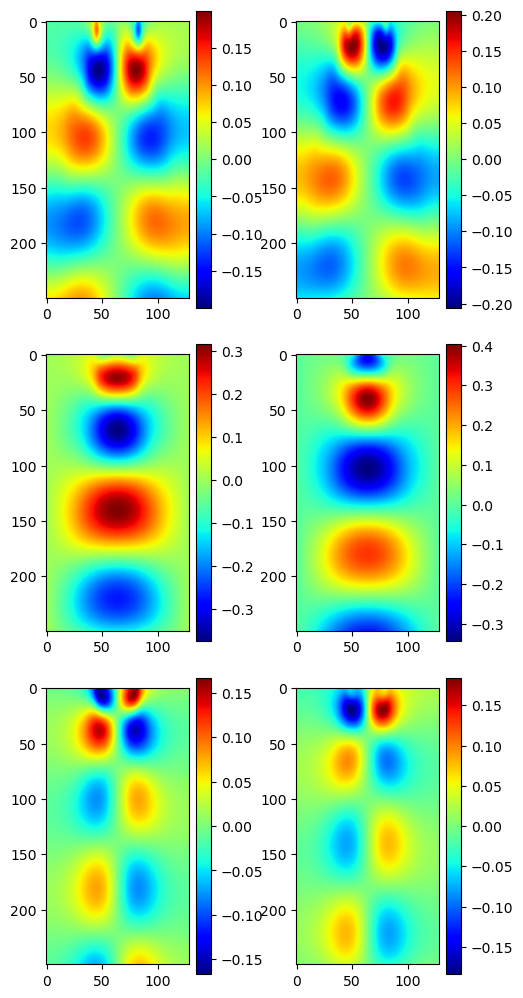

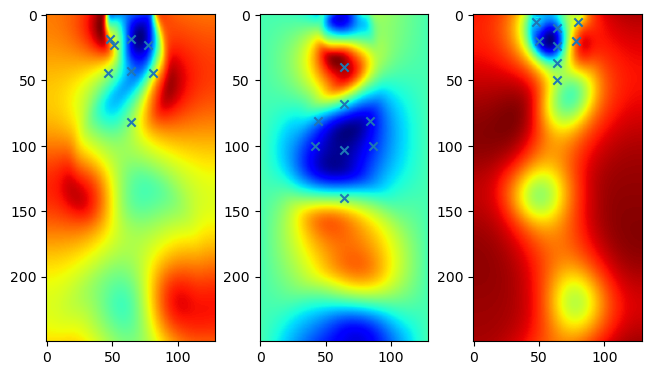

In [15]:
from flowrec.decomposition import POD
pod = POD('float32')
q, q_mean, grid_shape = pod.prepare_data(x,t_axis=1)
print(q.shape)
modes,lam,a,phi = pod.pod(q,grid_shape,method='snapshot',restore_shape=True)

fig,axes = plt.subplots(3,2,figsize=(5,10))
for i in range(3):
    im1 = axes[i,0].imshow(modes[i,:,:,0])
    plt.colorbar(im1)
    im2 = axes[i,1].imshow(modes[i,:,:,1])
    plt.colorbar(im2)

sx = []
sy = []
sp = []
mode_shape = modes[0,:,:,0].shape
for i in range(how_many_modes):
    sx.append(np.stack(np.unravel_index(np.argsort(modes[0,:,:,i],axis=None)[-nb_pairs:],mode_shape),axis=1))
    sy.append(np.stack(np.unravel_index(np.argsort(modes[1,:,:,i],axis=None)[-nb_pairs:],mode_shape),axis=1))
    sp.append(np.stack(np.unravel_index(np.argsort(modes[2,:,:,i],axis=None)[-nb_pairs:],mode_shape),axis=1))

    sx.append(np.stack(np.unravel_index(np.argsort(modes[0,:,:,i],axis=None)[:nb_pairs],mode_shape),axis=1))
    sy.append(np.stack(np.unravel_index(np.argsort(modes[1,:,:,i],axis=None)[:nb_pairs],mode_shape),axis=1))
    sp.append(np.stack(np.unravel_index(np.argsort(modes[2,:,:,i],axis=None)[:nb_pairs],mode_shape),axis=1))

sx = np.array(sx).reshape((how_many_modes*nb_pairs*2,-1)) # [# of sensors, coordinates]
sy = np.array(sy).reshape((how_many_modes*nb_pairs*2,-1))
sp = np.array(sp).reshape((how_many_modes*nb_pairs*2,-1))

fig,axes = plt.subplots(1,3)
axes[0].imshow(x[0,0,:,:])
axes[0].scatter(sx[:,1],sx[:,0],marker='x')
axes[1].imshow(x[1,0,:,:])
axes[1].scatter(sy[:,1],sy[:,0],marker='x')
axes[2].imshow(x[2,0,:,:])
axes[2].scatter(sp[:,1],sp[:,0],marker='x')

plt.show()

In [16]:
xi_pod = []
yi_pod = []
xi_pod.extend(sx[:,0])
xi_pod.extend(sy[:,0])
xi_pod.extend(sp[:,0])
yi_pod.extend(sx[:,1])
yi_pod.extend(sy[:,1])
yi_pod.extend(sp[:,1])
print('x coordinates: ', xi_pod)
print('y coordinates: ', yi_pod)

x coordinates:  [44, 44, 23, 23, 18, 18, 82, 43, 140, 68, 40, 103, 81, 81, 100, 100, 5, 5, 20, 20, 24, 50, 37, 10]
y coordinates:  [81, 47, 51, 77, 48, 64, 64, 64, 64, 64, 64, 64, 84, 44, 86, 42, 80, 48, 78, 50, 64, 64, 64, 64]


Pick some extra sensor points

In [119]:
modes.shape
print(np.unravel_index(np.argmax(modes[1,150:,:,1]),mode_shape))
print(np.unravel_index(np.argmin(modes[1,150:,:,1]),mode_shape))

(30, 64)
(99, 64)


In [127]:
sensors_extra = []
sensors_extra.append([21,64])
sensors_extra.append([220,64])
sensors_extra.append([180,64])
sensors_extra.append([249,64])
sensors_extra = np.array(sensors_extra)
sensors_extra.shape

xi_pod.extend(sensors_extra[:,0])
yi_pod.extend(sensors_extra[:,1])
print('x coordinates: ', xi_pod)
print('y coordinates: ', yi_pod)

x coordinates:  [44, 44, 23, 23, 140, 68, 40, 103, 5, 5, 20, 20, 21, 220, 180, 249]
y coordinates:  [81, 47, 51, 77, 64, 64, 64, 64, 80, 48, 78, 50, 64, 64, 64, 64]


# Make gif

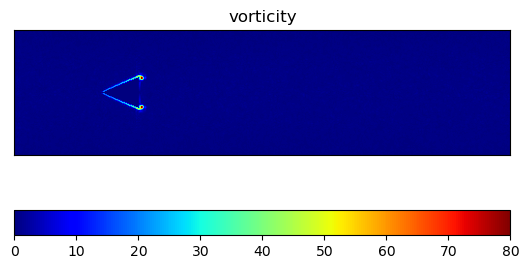

In [67]:
from matplotlib import animation

fps = 24
sec = 24
plt_data = np.einsum('t x y -> t y x',vort)
fig_gif = plt.figure()
im = plt.imshow(plt_data[0,:,:],vmin =-0.0, vmax=80.0, cmap='jet')
# im = plt.imshow(plt_data[0,:,:], cmap='jet')
plt.colorbar(orientation='horizontal')
plt.title('vorticity')
plt.xticks([])
plt.yticks([])
plt.show()


In [68]:
def animation_fun(i):
    im.set_array(plt_data[i,:,:])
    return[im]

# gif = animation.FuncAnimation(fig_gif,
#                                 animation_fun,
#                                 frames=np.arange(fps*sec),
#                                 interval=1000/fps,
#                                 repeat=False)
# gif.save('data_animation.gif',fps=fps)